In [1]:
import torch
import torch.nn as nn
from torch.nn import Module
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from BayesLinear import BayesLinear
from BayesTest import BayesLinear as BL
from Loss import BKLLoss

In [2]:
data = pd.read_csv('motorcycle.csv')

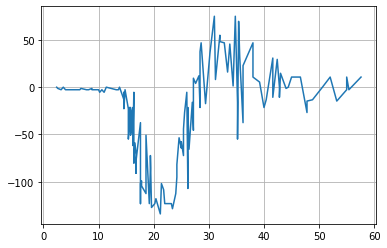

In [3]:
plt.figure()
plt.plot(data['times'], data['accel'])
plt.grid()
plt.show()

In [4]:
x = np.array(data['times'])
y = np.array(data['accel'])
print(type(x[0]))
x = torch.unsqueeze(torch.from_numpy(x), dim=1)
y = torch.unsqueeze(torch.from_numpy(y), dim=1)

x = x.float()
y = y.float()

print(x.shape, y.shape)

<class 'numpy.float64'>
torch.Size([133, 1]) torch.Size([133, 1])


In [9]:
class Net(Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_feature, out_features=n_hidden, bias=True)   # hidden layer
        self.hidden2 = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_hidden, bias=True)
        self.predict = BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=n_hidden, out_features=n_output, bias=True)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden1(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))      # activation function for hidden layer
        x = self.predict(x)             # linear output
        return x

In [10]:
net = Net(n_feature=1, n_hidden=100, n_output=1)     # define the network
print(net)  # net architecture

Net(
  (hidden1): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=1, out_features=100, bias=True)
  (hidden2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=100, bias=True)
  (predict): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=100, out_features=1, bias=True)
)


In [11]:
net = net.float()

optimizer = optim.Adam(net.parameters(), lr=0.01)
mse_loss = nn.MSELoss()

kl_loss = BKLLoss(reduction='mean', last_layer_only=False)
kl_weight = 0.01


for t in range(3000):
  
    prediction = net(x.float())     # input x and predict based on x
    mse = mse_loss(prediction, y.float())
    
    kl = kl_loss(net)
    cost = mse + kl_weight*kl
    
    optimizer.zero_grad()
    cost.float().backward()
    optimizer.step()
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

- MSE : 510.82, KL : 7.57


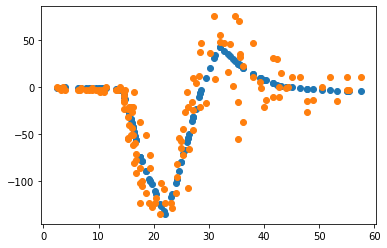

In [12]:
plt.figure()
plt.scatter(x, prediction.detach().numpy())
plt.scatter(x, y)
plt.show()